In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures/MBL"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1),aspect_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [7]:
def model(x,a,b):
    return a*x**b
def modelnn(x,a,b):
    return 2-a*x**(-b)

In [8]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"xx/h = 50 long",datapath/"xx/h = 75 long",datapath/"xx/h = 100 long",datapath/"xx/h = 24 ext"]
files = ["combined_file_h{}.jld2".format(h) for h in [50,75,100,24]] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])
folders_nn = [datapath/"xx_nn/h = 50 long",datapath/"xx_nn/h = 75 long",datapath/"xx_nn/h = 100 long",datapath/"xx_nn/h = 24 long",datapath/"xx_nn/h = 24 ext"]
files_nn = ["combined_file_h{}.jld2".format(h) for h in [50,75,100,24]] 
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

/tmp/ipykernel_70365/1174216589.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))


In [20]:
N = 13
hs = [50,75,100,24]
T = 10 ** np.linspace(-3,6,100)
Tl = 10 ** np.linspace(-3,12,200)
Tll = 10 ** np.linspace(-3,15,200)

xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [10]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

In [11]:
for i in range(len(files)):
    print(data[i].shape[2],"  nn ",data_nn[i].shape[2],"\n")

375   nn  350 

325   nn  575 

500   nn  500 

6000   nn  500 



# Disorder Averages

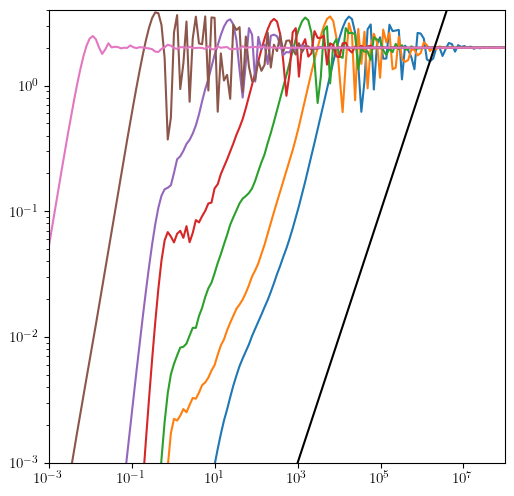

In [12]:
plt.semilogx(Tl,red[2])
#plt.semilogx(Tl,red[2],c="black")
plt.xlim(1e-3,1e8)
plt.ylim(1e-3,4)
plt.plot(Tl,Tl/1e6,c="black")
plt.yscale("log")

In [25]:
def modelnn3(x,a,b,c):
    return 2-a*np.exp(-(b*x)**c)

In [37]:
Tl[100]

34489.62260405753

In [38]:
popt_nn = []
perr_nn = []
tfitmax = [200,200,200,200,200]
tfitmin = [50,50,50,50,50]
for j in range(5):
    poptj, pcovj = curve_fit(modelnn3,Tl[tfitmin[j]:tfitmax[j]],red_nn[0][tfitmin[j]:tfitmax[j],j])
    popt_nn.append(poptj)
    perr_nn.append(np.sqrt(np.diag(pcovj)))

/tmp/ipykernel_70365/796212367.py:2: RuntimeWarning: invalid value encountered in power
  return 2-a*np.exp(-(b*x)**c)


In [39]:
popt_nn

[array([2.12080574e+00, 4.74799021e-08, 2.16155774e-01]),
 array([2.16557297e+00, 4.42633818e-07, 2.17100120e-01]),
 array([2.13636821e+00, 1.08065052e-05, 2.52682202e-01]),
 array([2.36200106e+00, 9.39328275e-04, 2.70979298e-01]),
 array([1.59578661, 0.02365673, 0.84450312])]

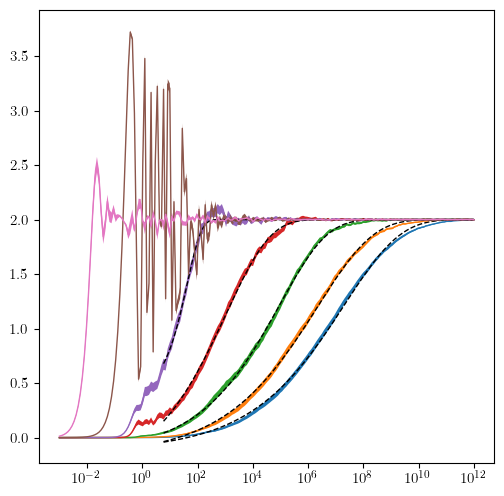

In [40]:
for j in range(0,N//2+1):
    plt.plot(Tl,red_nn[0][:,j],label="r={}".format(rvals[j]),lw=1)
    if j<=4:
        plt.plot(Tl[tfitmin[j]:tfitmax[j]],modelnn3(Tl[tfitmin[j]:tfitmax[j]],*popt_nn[j]),c="black",ls="dashed",lw=1)
    plt.fill_between(Tl, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j])
plt.xscale("log")

(0.001, 4.0)

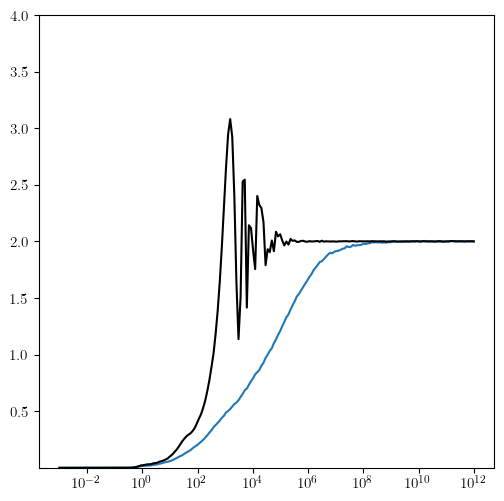

In [13]:
plt.semilogx(Tl,red_nn[0][:,2])
plt.semilogx(Tl,red[0][:,2],c="black")
plt.ylim(1e-3,4)

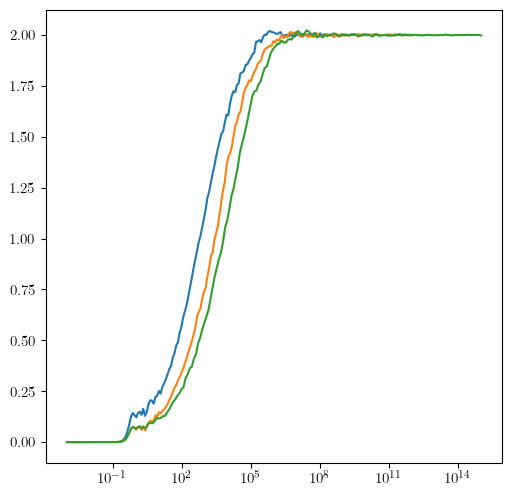

In [45]:
plt.semilogx(Tl,red_nn[0][:,3])
plt.semilogx(Tl,red_nn[1][:,3])
plt.semilogx(Tll,red_nn[2][:,3])

In [78]:
popt = []
perr = []
tfitmax = [95,90,80,70,60]
tfitmin = [0,0,0,0,0]
for j in range(5):
    poptj, pcovj = curve_fit(model,Tl[tfitmin[j]:tfitmax[j]],red[0][tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [79]:
popt

[array([3.01278974e-04, 9.69172728e-01]),
 array([0.00148071, 0.89760877]),
 array([0.01058429, 0.78273209]),
 array([0.05230664, 0.73838169]),
 array([0.40356943, 0.63618838])]

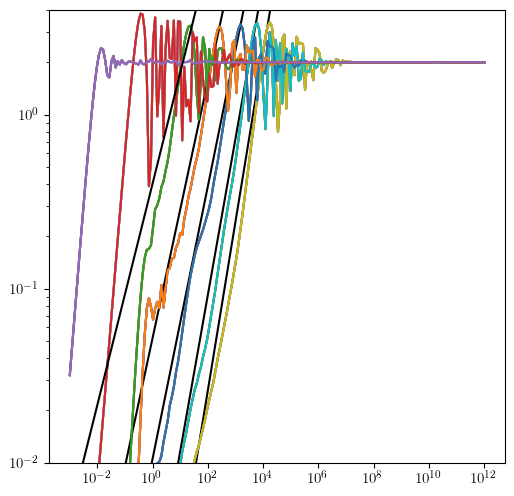

In [80]:
for j in range(5):
    plt.semilogx(Tl,red[1])
    plt.semilogx(Tl,model(Tl,*popt[j]),c="black")
plt.ylim(1e-2,4)
plt.yscale("log")

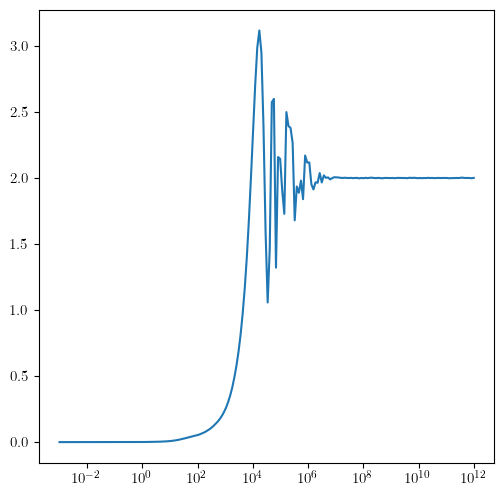

In [62]:
l = 0
plt.semilogx(Tl,red[0][:,l])
#plt.semilogx(Tl,red[1][:,l])
#plt.semilogx(Tl,red[2][:,l])